In [4]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
import evaluate

RUN_NAME = "data_v1"
data = pd.read_csv(RUN_NAME + ".csv")

In [6]:
data['prediction'] = data['Text']
rouge = evaluate.load('rouge')

In [9]:
data["rouge1"] = -1
data['rouge2'] = -1
data['rougeL'] = -1
data['rougeLsum'] = -1

for idx, row in data.iterrows():
    pred = ["\n".join(sent_tokenize(row['prediction'].strip()))]
    summary = ["\n".join(sent_tokenize(row['Summary'].strip()))]
    result = rouge.compute(predictions=pred, references=summary)
    data.loc[idx, "rouge1"] = result['rouge1']
    data.loc[idx, "rouge2"] = result['rouge2']
    data.loc[idx, "rougeL"] = result['rougeL']
    data.loc[idx, "rougeLsum"] = result['rougeLsum']

In [10]:
data.head()

,Unnamed: 0,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score,prediction,rouge1,rouge2,rougeL,rougeLsum
0,0,Notion,Twitter,If anyone wants to test out the new Arc browse...,User is excited about the new features in the ...,87,74,0.850575,0.377880,If anyone wants to test out the new Arc browse...,0.179310,0.027972,0.151724,0.179310
1,1,Notion,Appstore/Playstore,I used it well on my laptop but on the iPad wh...,User experienced issues with the app not worki...,62,27,0.435484,0.624350,I used it well on my laptop but on the iPad wh...,0.202247,0.045977,0.089888,0.157303
2,2,zoom,Appstore/Playstore,Love it,User loves Zoom.,3,3,1.000000,0.225060,Love it,0.000000,0.000000,0.000000,0.000000
3,3,Notion,Appstore/Playstore,Not userfriendly at all,Nothing,5,1,0.200000,0.173104,Not userfriendly at all,0.000000,0.000000,0.000000,0.000000
4,4,Notion,Appstore/Playstore,Its the same right Just relax,Nothing,7,1,0.142857,0.002279,Its the same right Just relax,0.000000,0.000000,0.000000,0.000000


In [11]:
all_metrics = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
for metric in all_metrics:
    print(data.groupby("Customer")[metric].mean())

Customer
Notion    0.190757
figma     0.118953
zoom      0.074199
Name: rouge1, dtype: float64
Customer
Notion    0.062970
figma     0.005400
zoom      0.031421
Name: rouge2, dtype: float64
Customer
Notion    0.150353
figma     0.081369
zoom      0.070911
Name: rougeL, dtype: float64
Customer
Notion    0.159814
figma     0.099667
zoom      0.070911
Name: rougeLsum, dtype: float64


In [12]:
all_metrics = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
for metric in all_metrics:
    print(data.groupby("Type")[metric].mean())

Type
Appstore/Playstore    0.233126
G2                    0.155940
Twitter               0.114003
Name: rouge1, dtype: float64
Type
Appstore/Playstore    0.108173
G2                    0.007049
Twitter               0.012055
Name: rouge2, dtype: float64
Type
Appstore/Playstore    0.191823
G2                    0.099710
Twitter               0.085462
Name: rougeL, dtype: float64
Type
Appstore/Playstore    0.198429
G2                    0.132641
Twitter               0.095296
Name: rougeLsum, dtype: float64


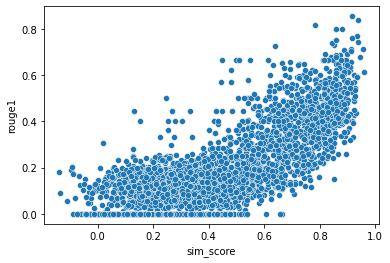

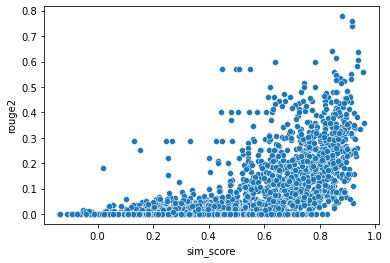

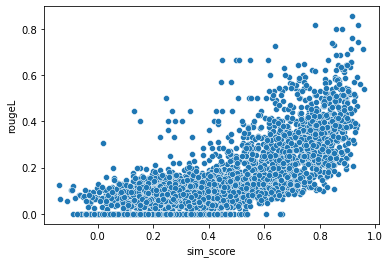

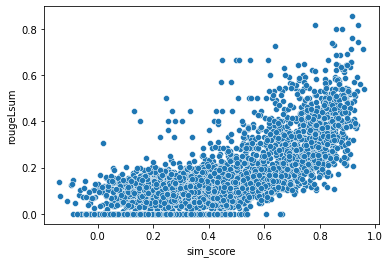

In [14]:
all_metrics = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
for metric in all_metrics:
    sns.scatterplot(x = "sim_score", y = metric, data = data)
    plt.show()